In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Likelihood Calculation Setup

In [140]:
BUG_FIELDS = [
    'P(Friendship|Friday)',
    'P(Relationship|Friday)',
    'P(Hookup|Friday)',
    'P(Friendship|Bored)',
    'P(Relationship|Bored)',
    'P(Hookup|Bored)',
    'P(Friendship|Missed Show)',
    'P(Relationship|Missed Show)',
    'P(Hookup|Missed Show)',
]

multi_answer_demographic_keys = ['Race', 'Major']

single_answer_demographic_keys = ['Gender', 'Sexuality', 'Age']

In [141]:
prior_df = pd.read_csv('prior_data.csv')
for key in multi_answer_demographic_keys:
    prior_df[key] = [eval(val) for val in prior_df[key]]

posterior_df = pd.read_csv('posterior_data.csv')
for key in multi_answer_demographic_keys:
    posterior_df[key] = [eval(val) for val in posterior_df[key]]
non_bug_posterior_df = posterior_df[posterior_df['Has Bug'] == False]
posterior_df.drop(BUG_FIELDS, axis = 1, inplace = True)

In [142]:
prior_keys = [k for k in list(prior_df.columns) if k.startswith('P')]
posterior_keys = [k for k in list(posterior_df.columns) if k.startswith('P') and k not in BUG_FIELDS]

In [143]:
# reorder the prior keys to match the posterior keys
def reorder_keys(full_prior_keys, full_posterior_keys):
    # create tuples of a, b from P(a|b) or P(b|a)
    prior_order = [k[2:-1].split('|')[::-1] for k in full_prior_keys]
    posterior_order = [k[2:-1].split('|') for k in full_posterior_keys]
    return np.array([prior_order.index(k) for k in posterior_order])

In [144]:
def compute_prior_posterior(prior_df, posterior_df, non_bug_posterior_df):
    # compute prior
    arr = prior_df[prior_keys].to_numpy(dtype = np.float32).T
    prior_avg = np.mean(arr, axis = 1)

    # compute posterior
    arr = posterior_df[posterior_keys].to_numpy(dtype = np.float32).T
    posterior_avg = np.mean(arr, axis = 1)
    arr = non_bug_posterior_df[BUG_FIELDS].to_numpy(dtype = np.float32).T
    non_bug_posterior_avg = np.mean(arr, axis = 1)
    posterior_avg = np.append(posterior_avg, non_bug_posterior_avg)

    # rearrange prior to match posterior
    prior_avg = prior_avg[reorder_keys(prior_keys, posterior_keys + BUG_FIELDS)]
    return prior_avg, posterior_avg

We also experimented with a modified KL loss where we computed the KL divergence for each text message and then took the worst \
divergence value across messages as the loss. This did not have a noticeable difference in the optimal likelihood.

In [145]:
# P is ground truth; Q is a model
def KL(P, Q):
    return np.sum(P * (np.log(P) - np.log(Q)))

In [146]:
def normalize_posterior_approx(non_normalized):
    sums = np.array([np.sum(non_normalized[i * 3:(i+1) * 3]) for i in range(10)])
    return non_normalized / np.repeat(sums, 3)

In [147]:
# we consider intervals of 1 / step_ct; all values of likelihood must be nonzero
# order of likelihood is friendship, relationship, hookup
def grid_search(prior_avg, posterior_avg, step_ct = 100):
    divergences = dict()
    i_arr = np.arange(step_ct - 2) + 1
    for i in i_arr:
        j_arr = np.arange(step_ct - i - 1) + 1
        for j in j_arr:
            k = step_ct - i - j
            likelihood = np.tile(np.array([i, j, k]), 10) / step_ct
            posterior_approx = normalize_posterior_approx(prior_avg * likelihood)
            divergences[(i / step_ct, j / step_ct, k / step_ct)] = KL(posterior_avg, posterior_approx)
    return divergences

In [290]:
def calculate_likelihood(prior_df, posterior_df, non_bug_posterior_df):
    prior_avg, posterior_avg = compute_prior_posterior(prior_df, posterior_df, non_bug_posterior_df)
    # avoid division by zero issues
    eps = 1e-12
    prior_avg += eps
    posterior_avg += eps
    divergences = grid_search(prior_avg, posterior_avg, step_ct = 100)
    optimal, KL_score = min(divergences.items(), key = lambda x: x[1])
    likelihood = np.repeat(np.array(optimal), 10)
    posterior_approx = normalize_posterior_approx(prior_avg * likelihood)
    return optimal, np.round(KL_score, 2), posterior_approx, posterior_avg

In [291]:
def plot_likelihood(prior_df, posterior_df, non_bug_posterior_df):
    optimal, KL_score, posterior_approx, posterior_avg = calculate_likelihood(prior_df, posterior_df, non_bug_posterior_df)
    xticks = [k.replace('Friendship', 'Intent') for k in (posterior_keys + BUG_FIELDS) if 'Friendship' in k]
    for i in range(10):
        plt.plot(np.arange(3) + 3 * i, posterior_approx[3 * i : 3 * (i+1)], color = 'red', 
                label = 'Modelled Posterior' if i == 0 else None, marker = '.')
        plt.plot(np.arange(3) + 3 * i, posterior_avg[3 * i : 3 * (i+1)], color = 'blue', 
                label = 'Observed Posterior' if i == 0 else None,  marker = '.')
    plt.title(f"Optimal Likelihood: Friendship, Relationship, Hookup = {optimal} KL: {KL_score}")
    plt.xticks(np.arange(10) * 3 + 1, xticks, rotation = 90)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()

# General Likelihood Calculation

Note the top 10 likelihood values are all very similar. This makes sense because the model and loss surface are pretty simple, and it also tells us that we're likely getting close to the true global optimum likelihood

In [292]:
prior_avg, posterior_avg = compute_prior_posterior(prior_df, posterior_df, non_bug_posterior_df)
divergences = grid_search(prior_avg, posterior_avg, step_ct = 100)
sorted(divergences.items(), key = lambda x: x[1])[:10]

[((0.54, 0.27, 0.19), 0.7657681901595392),
 ((0.55, 0.26, 0.19), 0.7677732436195142),
 ((0.53, 0.27, 0.2), 0.7680035073821065),
 ((0.55, 0.27, 0.18), 0.7681354063810351),
 ((0.53, 0.28, 0.19), 0.7685599729061103),
 ((0.54, 0.26, 0.2), 0.7694213912194109),
 ((0.54, 0.28, 0.18), 0.770362150067048),
 ((0.56, 0.26, 0.18), 0.7706273869684659),
 ((0.52, 0.28, 0.2), 0.7714621608152157),
 ((0.52, 0.27, 0.21), 0.7744023066007599)]

The observed posterior is computed using the data we collected, while the modelled posterior is the closest we can get by using the observed prior and an approximate optimal likelihood. This optimal likelihood is found via grid search by searching through all values with a step size of 0.01 &mdash; it's approximate because of this step size.

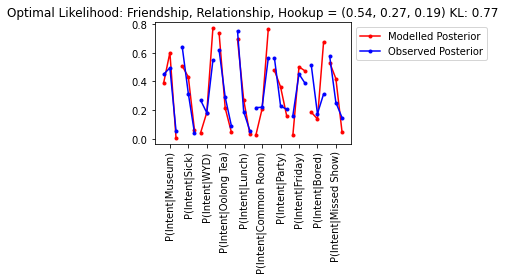

In [293]:
plot_likelihood(prior_df, posterior_df, non_bug_posterior_df)

# Likelihood Calculation by Demographics

In [294]:
demographic_dict = {
    'Race': ['White', 'Black', 'American Indian or Alaska Native', 'Asian', 'Native Hawaiian or Pacific Islander', 
             'Hispanic'],
    'Major': ['Arts', 'Humanities', 'STEM + Econ', 'Social Sciences'],
    'Gender': ['Man', 'Woman', 'Nonbinary'],
    'Sexuality': ['Heterosexual', 'Lesbian', 'Gay', 'Bisexual', 'Asexual']
}

skip_demographic_dict = {
    'Race': ['American Indian or Alaska Native', 'Native Hawaiian or Pacific Islander'],
    'Major': [],
    'Gender': [],
    'Sexuality': [],
    'Age': [18]
}

In [316]:
def plot_likelihood_by_demographic(prior_df, posterior_df, non_bug_posterior_df, demographic):
    if demographic not in multi_answer_demographic_keys + single_answer_demographic_keys:
        raise KeyError(f"{demographic} is not a valid demographic")
    labels = sorted(list(set(prior_df['Age']))) if demographic == 'Age' else demographic_dict[demographic]
    is_single = demographic in single_answer_demographic_keys

    num = len(labels) - len(skip_demographic_dict[demographic])
    fig, ax = plt.subplots(num, 1, figsize=(5, 5 * num))
    counter = 0
    for index in range(1, len(labels) + 1):
        if labels[index - 1] in skip_demographic_dict[demographic]:
            continue
        if is_single:
            val = labels[index - 1] if demographic == 'Age' else index
            temp_posterior_df = posterior_df[posterior_df[demographic] == val]
            temp_non_bug_posterior_df = non_bug_posterior_df[non_bug_posterior_df[demographic] == val]
        else:
            temp_posterior_df = posterior_df[[(index in lst) for lst in posterior_df[demographic]]]
            temp_non_bug_posterior_df = non_bug_posterior_df[[(index in lst) for lst in non_bug_posterior_df[demographic]]]
        # skip if there isn't any data
        if temp_posterior_df.empty or temp_non_bug_posterior_df.empty:
            raise ValueError(f"This demographic {labels[index - 1]} should be skipped")

        optimal, KL_score, posterior_approx, posterior_avg = calculate_likelihood(prior_df, temp_posterior_df, 
                                                                        temp_non_bug_posterior_df)
        xticks = [k.replace('Friendship', 'Intent') for k in (posterior_keys + BUG_FIELDS) if 'Friendship' in k]
        for i in range(10):
            ax[counter].plot(np.arange(3) + 3 * i, posterior_approx[3 * i : 3 * (i+1)], color = 'red', 
                    label = 'Modelled Posterior' if i == 0 else None, marker = '.')
            ax[counter].plot(np.arange(3) + 3 * i, posterior_avg[3 * i : 3 * (i+1)], color = 'blue', 
                    label = 'Observed Posterior' if i == 0 else None,  marker = '.')
        ax[counter].set_title((f"Friendship, Relationship, Hookup = {optimal}     {demographic}: {labels[index-1]}   "
                              f"KL: {KL_score}   Count: {temp_posterior_df.shape[0]}"))
        ax[counter].set_xticks(np.arange(10) * 3 + 1)
        ax[counter].set_xticklabels(xticks, rotation = 90)
        ax[counter].legend(bbox_to_anchor=(1, 1))
        counter += 1
    plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=0.9,
                    top=0.9,
                    wspace=0.9,
                    hspace=1)

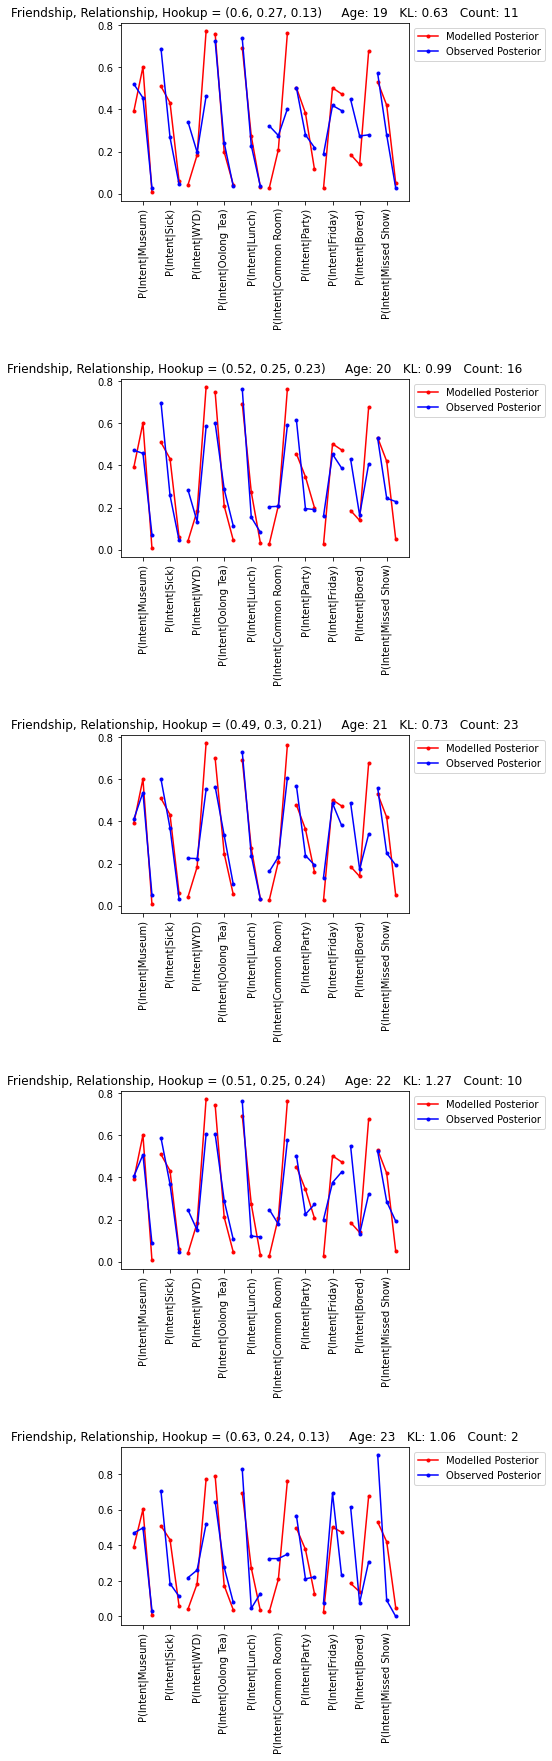

In [322]:
plot_likelihood_by_demographic(prior_df, posterior_df, non_bug_posterior_df, 'Age')

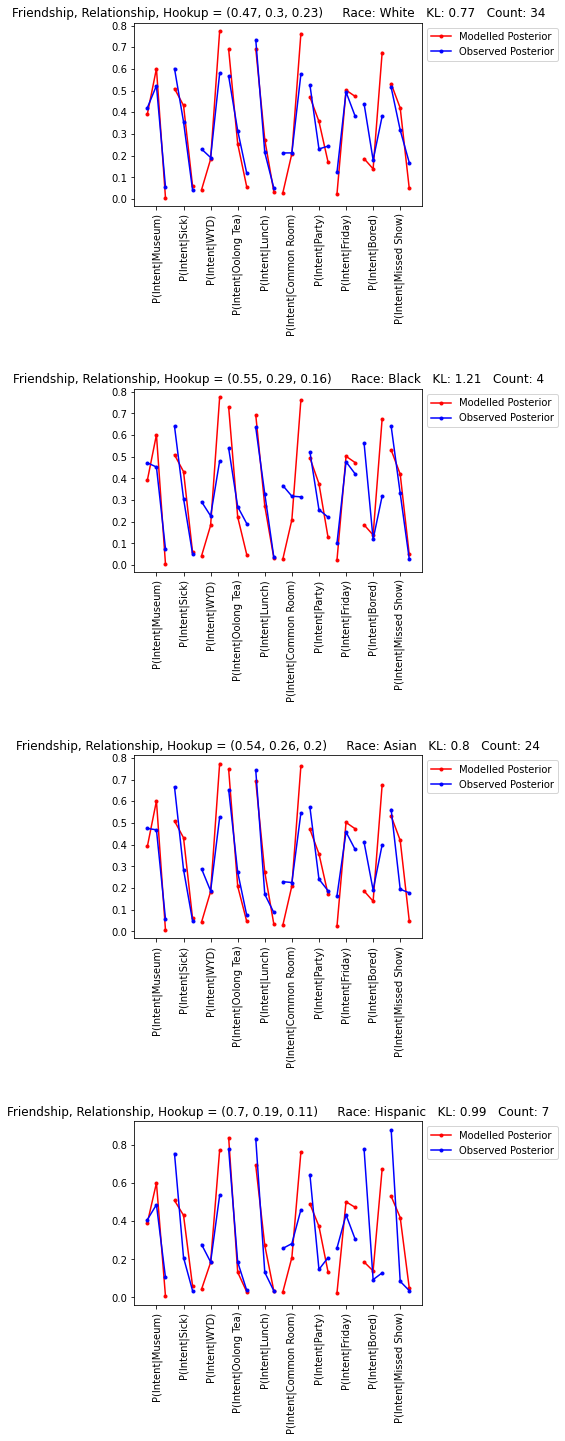

In [323]:
plot_likelihood_by_demographic(prior_df, posterior_df, non_bug_posterior_df, 'Race')

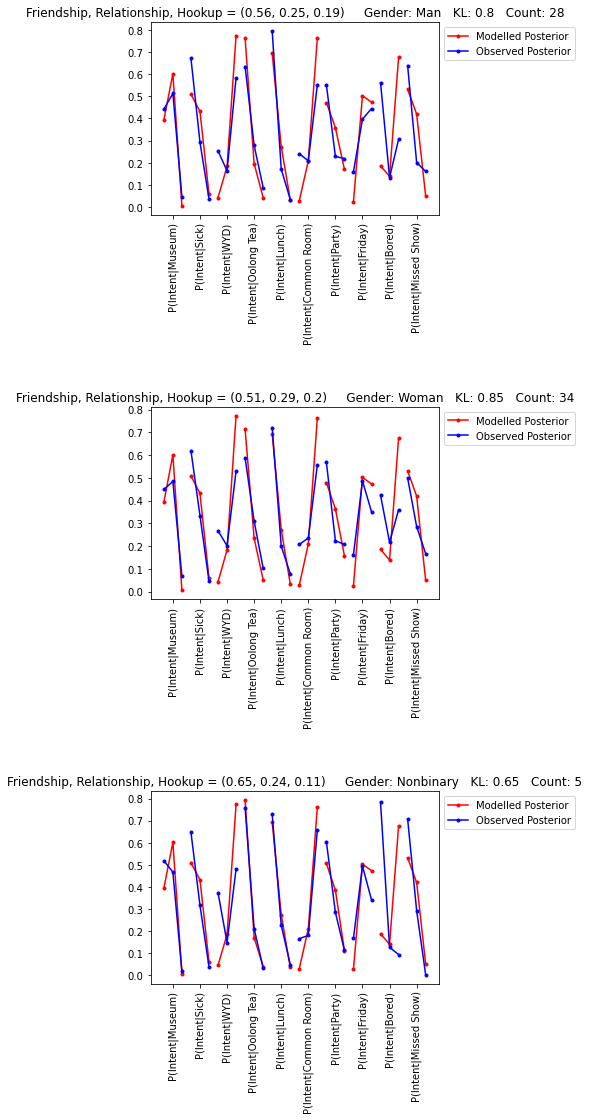

In [324]:
plot_likelihood_by_demographic(prior_df, posterior_df, non_bug_posterior_df, 'Gender')

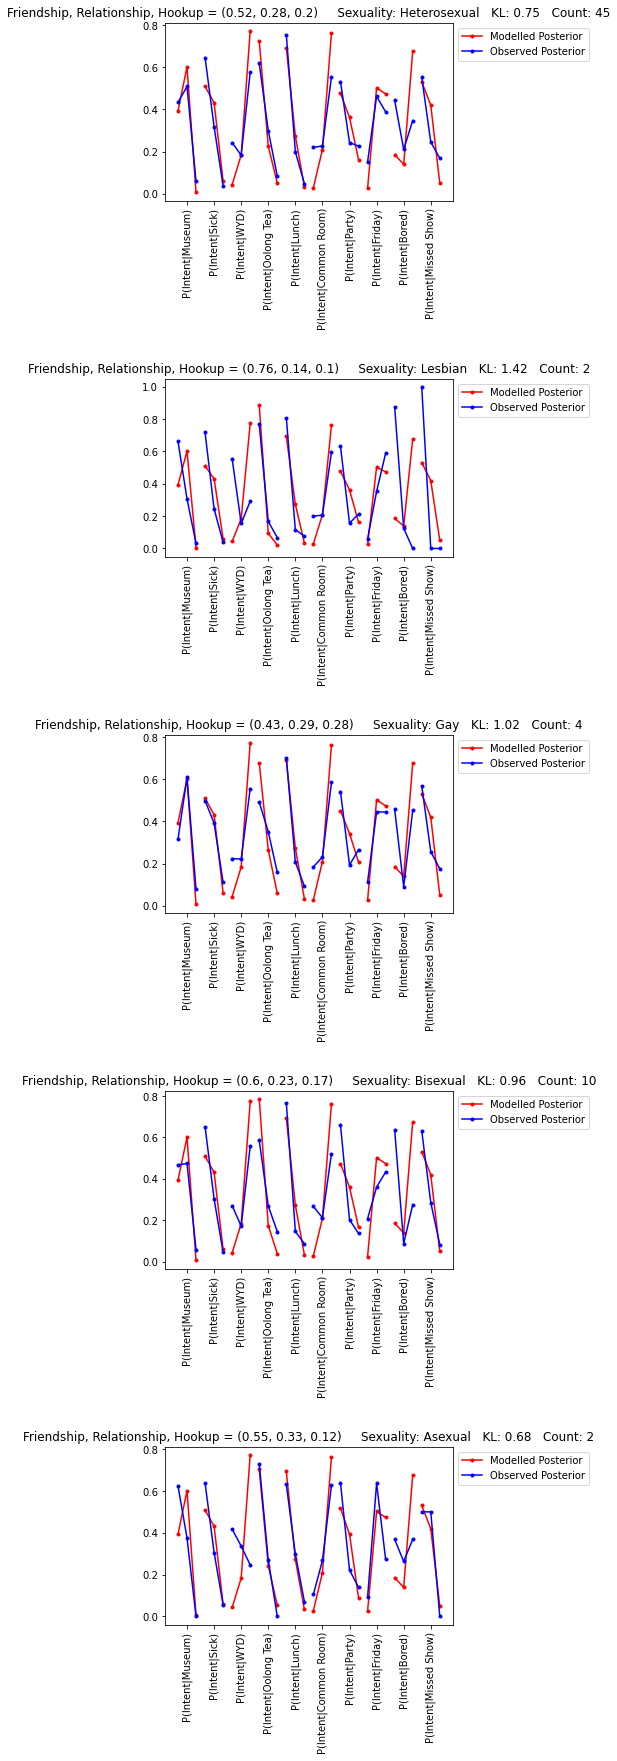

In [320]:
plot_likelihood_by_demographic(prior_df, posterior_df, non_bug_posterior_df, 'Sexuality')

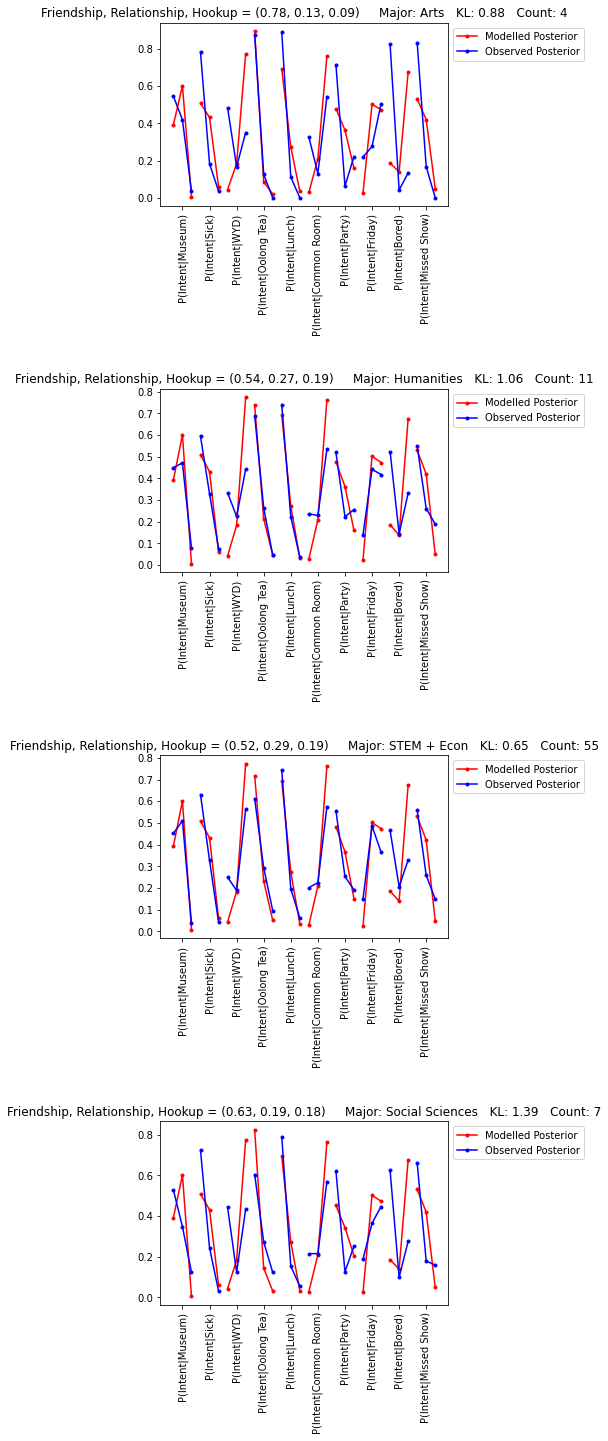

In [321]:
plot_likelihood_by_demographic(prior_df, posterior_df, non_bug_posterior_df, 'Major')